In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torch.utils.data import Dataset, DataLoader
import math
import pandas as pd
import random
import os
import copy
import time


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/otto-group-product-classification-challenge/sampleSubmission.csv
/kaggle/input/otto-group-product-classification-challenge/train.csv
/kaggle/input/otto-group-product-classification-challenge/test.csv


In [2]:
df_train = pd.read_csv('/kaggle/input/otto-group-product-classification-challenge/train.csv')
df_test = pd.read_csv('/kaggle/input/otto-group-product-classification-challenge/test.csv')
sampleSub = pd.read_csv('/kaggle/input/otto-group-product-classification-challenge/sampleSubmission.csv')
df_train

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,...,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61873,61874,1,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,2,0,Class_9
61874,61875,4,0,0,0,0,0,0,0,0,...,0,2,0,0,2,0,0,1,0,Class_9
61875,61876,0,0,0,0,0,0,0,3,1,...,0,3,1,0,0,0,0,0,0,Class_9
61876,61877,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,3,10,0,Class_9


In [3]:
df_train = df_train.set_index('id')
df_test = df_test.set_index('id')

In [4]:
x_train = df_train.drop('target', axis = 1).to_numpy(dtype = np.float32)
y_train = df_train['target'].str.split('_', expand = True)[1].to_numpy(dtype = np.int32)
y_train = y_train-1
y_train

array([0, 0, 0, ..., 8, 8, 8], dtype=int32)

In [5]:
x_test = df_test.to_numpy(dtype = np.float32)
x_test

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 2.,  2., 14., ...,  0.,  2.,  0.],
       [ 0.,  1., 12., ...,  0.,  0.,  1.],
       ...,
       [ 0.,  1.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [6]:
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(
    torch.from_numpy(x_train).float(),
    torch.from_numpy(y_train).long()
)
test_dataset = TensorDataset(
    torch.from_numpy(x_test).float()
)

In [7]:
from torch.utils.data import random_split

train_split = 0.8
batch_size = 64 * 2
num_workers = 4
lr = 0.001
Epoch = 50

train_len = int(len(train_dataset) * train_split)
val_len = len(train_dataset) - train_len

train_dataset, val_dataset = random_split(train_dataset, [train_len, val_len])

train_dataloader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = num_workers
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = num_workers
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = num_workers
)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
# from torchsummary import summary

# class Model(nn.Module):
#     def __init__(self):
#         super(Model,self).__init__()
#         self.fc1 = nn.Linear(93, 512)
#         self.bn1 = nn.BatchNorm1d(512)
#         self.dropout = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(512, 256)
#         self.bn2 = nn.BatchNorm1d(256)
#         self.fc3 = nn.Linear(256,)
#         self.relu = nn.ReLU()

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        # 定义一次所有层
        self.fc1 = nn.Linear(93, 4096)
        self.bn1 = nn.BatchNorm1d(4096)
        
        self.fc2 = nn.Linear(4096, 2048)
        self.bn2 = nn.BatchNorm1d(2048)
        self.drop1 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(2048, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.drop2 = nn.Dropout(0.4)
        
        self.fc4 = nn.Linear(512, 81)
        self.bn4 = nn.BatchNorm1d(81)
        self.drop3 = nn.Dropout(0.3)
        
        self.fc5 = nn.Linear(81, 9)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.drop1(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.drop2(x)
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.drop3(x)
        x = self.fc5(x)
        return x

In [10]:
model = MyNet().to(device)
# summary(model, (93,))

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

In [12]:
def train_model_process(model, train_dataloader, val_dataloader, Epoch = Epoch, lr = lr):
    # 复制模型参数
    best_model_wts = copy.deepcopy(model.state_dict())

    # 初始化参数
    best_acc, best_epoch = 0,0
    # 训练集损失列表
    train_loss_all = []
    # 验证集损失列表
    val_loss_all = []

    # 训练集准确度列表
    train_acc_all = []
    # 验证集准确度列表
    val_acc_all = []

    since = time.time()
    since1 = 0
    time_use = 0

    for epoch in range(Epoch):
        print(f'Epoch {epoch}/{Epoch-1}')

        train_loss = 0.0
        train_corrects = 0
        train_num = 0
        val_loss = 0.0
        val_corrects = 0
        val_num = 0

        # 训练
        for batch_idx, (x, y) in enumerate(train_dataloader, 0):
            x = x.to(device)
            y = y.to(device)

            model.train()

            y_pred = model(x)
            pred_label = torch.argmax(y_pred, dim = 1)
            
            loss = criterion(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x.size(0)
            train_corrects += (pred_label == y.detach()).sum()
            train_num += x.size(0)
        
        # 验证
        for batch_idx, (x, y) in enumerate(val_dataloader, 0):
            x = x.to(device)
            y = y.to(device)

            model.eval()
            
            y_pred = model(x)
            pred_label = torch.argmax(y_pred, dim = 1)
            
            loss = criterion(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            val_loss += loss.item() * x.size(0)
            val_corrects += (pred_label == y.detach()).sum()
            val_num += x.size(0)

        # 计算并保存每一次Epoch迭代的loss值和准确率 
        train_loss_epoch = train_loss / train_num
        train_acc_epoch = train_corrects.double().item() / train_num
        val_loss_epoch = val_loss / val_num
        val_acc_epoch = val_corrects.double().item() / val_num
        
        train_loss_all.append(train_loss_epoch)
        train_acc_all.append(train_acc_epoch)
        val_loss_all.append(val_loss_epoch)
        val_acc_all.append(val_acc_epoch)    

        print(f'Train Loss: {train_loss_epoch:.4f}, Train Acc: {train_acc_epoch:.4f}')
        print(f'Val   Loss: {val_loss_epoch:.4f}, Val   Acc: {val_acc_epoch:.4f}')

        if val_acc_epoch > best_acc:
            best_acc = val_acc_epoch
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())

        since1 = time.time() - since - time_use
        time_use = time.time() - since

        print(f'当前轮耗时: {since1}s')
        print(f'训练总耗时: {time_use}s')


    torch.save(best_model_wts,  './best_model.pth')
    print('\n' + '#'*50)
    print(f'best epoch: {best_epoch}, best acc {best_acc:.2f}')
    
    train_progress = pd.DataFrame(data = {
        'epoch': range(Epoch),
        'train_loss_all': train_loss_all,
        'val_loss_all': val_loss_all,
        'train_acc_all': train_acc_all,
        'val_acc_all': val_acc_all
    })
    return train_progress

In [13]:
def matplot_acc_loss(train_process):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(train_process["epoch"],train_process.train_loss_all,label="train loss")
    plt.plot(train_process["epoch"],train_process.val_loss_all,label="val loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")

    plt.subplot(1,2,2)
    plt.plot(train_process["epoch"],train_process.train_acc_all,label="train acc")
    plt.plot(train_process["epoch"],train_process.val_acc_all,label="val acc")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("acc")

    plt.show()

In [14]:
train_process = train_model_process(model , train_dataloader , val_dataloader)

Epoch 0/49
Train Loss: 0.7361, Train Acc: 0.7370
Val   Loss: 0.5723, Val   Acc: 0.7803
当前轮耗时: 3.436544418334961s
训练总耗时: 3.4365453720092773s
Epoch 1/49
Train Loss: 0.5958, Train Acc: 0.7740
Val   Loss: 0.5168, Val   Acc: 0.7990
当前轮耗时: 2.978191614151001s
训练总耗时: 6.414738178253174s
Epoch 2/49
Train Loss: 0.5627, Train Acc: 0.7837
Val   Loss: 0.4890, Val   Acc: 0.8053
当前轮耗时: 2.864595651626587s
训练总耗时: 9.279334545135498s
Epoch 3/49
Train Loss: 0.5332, Train Acc: 0.7931
Val   Loss: 0.4679, Val   Acc: 0.8121
当前轮耗时: 2.8820137977600098s
训练总耗时: 12.161349296569824s
Epoch 4/49
Train Loss: 0.5169, Train Acc: 0.7996
Val   Loss: 0.4501, Val   Acc: 0.8207
当前轮耗时: 2.8342533111572266s
训练总耗时: 14.995603322982788s
Epoch 5/49
Train Loss: 0.5009, Train Acc: 0.8036
Val   Loss: 0.4318, Val   Acc: 0.8279
当前轮耗时: 2.90177845954895s
训练总耗时: 17.897382497787476s
Epoch 6/49
Train Loss: 0.4837, Train Acc: 0.8101
Val   Loss: 0.4236, Val   Acc: 0.8315
当前轮耗时: 2.9173061847686768s
训练总耗时: 20.81468963623047s
Epoch 7/49
Train Loss

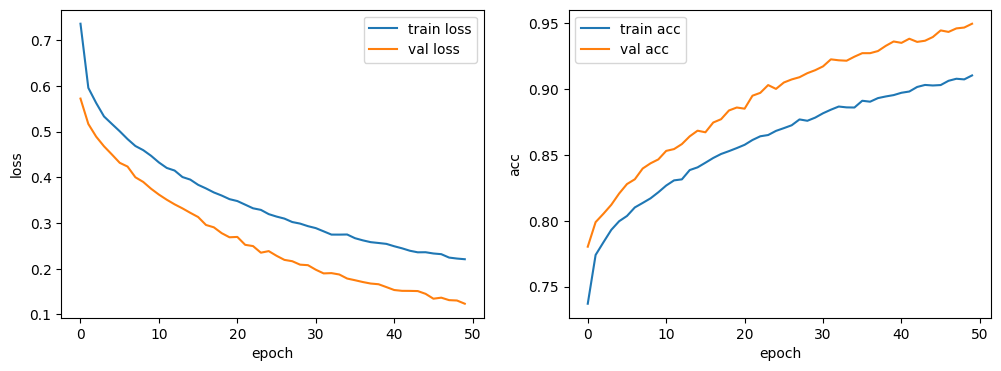

In [15]:
matplot_acc_loss(train_process)

In [16]:
def test(model, test_dataloader):
    res = []

    with torch.no_grad():
        for x in test_dataloader:
            x = x[0]
            x = x.to(device)
            model.eval()
            y_pred = model(x)

            p = F.softmax(y_pred, dim = 1)
            p_list = p.cpu().detach().numpy().tolist()
            res.extend(p_list)
    return res

In [17]:
best_model = MyNet().to(device)
best_model.load_state_dict(torch.load('/kaggle/working/best_model.pth', map_location=device))

/tmp/ipykernel_19/255895903.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('/kaggle/working/best_model.pth', map_location=device))

<All keys matched successfully>

In [18]:
res = test(best_model, test_dataloader)

In [19]:
res[:2]

[[1.2188404241442186e-07,
  0.008416787721216679,
  0.8357319235801697,
  0.15584707260131836,
  1.8403006896150487e-09,
  4.378912876745744e-08,
  2.404524821031373e-06,
  2.0470136519179505e-07,
  1.4789962961003766e-06],
 [6.045247635810824e-11,
  6.159437543340474e-11,
  5.1810491660808644e-12,
  5.463564045626867e-10,
  7.451226864251675e-15,
  0.9999940395355225,
  2.260845954893398e-10,
  5.992134902044199e-06,
  3.897438205502368e-10]]

In [20]:
import csv

submission = [['id']]
for i in range(1,10):
    submission[0].append('Class_' + str(i))
    
for i in range(len(res)):
    t = res[i]
    submission.append([i+1] + t)
with open('submission.csv', 'w') as submissionFile:
    writer = csv.writer(submissionFile)
    writer.writerows(submission)
    
print('Writing Complete!')

Writing Complete!


In [21]:
sub = pd.read_csv("./submission.csv")
sub

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,1,1.218840e-07,8.416788e-03,8.357319e-01,1.558471e-01,1.840301e-09,4.378913e-08,2.404525e-06,2.047014e-07,1.478996e-06
1,2,6.045248e-11,6.159438e-11,5.181049e-12,5.463564e-10,7.451227e-15,9.999940e-01,2.260846e-10,5.992135e-06,3.897438e-10
2,3,4.771346e-10,2.821489e-17,1.367429e-20,4.705203e-13,1.388948e-18,1.000000e+00,2.072958e-13,7.507537e-11,5.457647e-11
3,4,2.118135e-08,9.841307e-01,1.586712e-02,2.034999e-06,4.624645e-10,9.890404e-12,6.335750e-09,1.996781e-08,2.731884e-08
4,5,9.478520e-04,3.414247e-11,1.075664e-13,3.430650e-12,4.034487e-10,1.386928e-06,1.404454e-09,2.244606e-09,9.990507e-01
...,...,...,...,...,...,...,...,...,...,...
144363,144364,9.506509e-02,2.405638e-08,3.391009e-10,2.949430e-04,1.587815e-07,9.041800e-01,6.645897e-07,9.032487e-06,4.500613e-04
144364,144365,4.277575e-06,9.219691e-02,8.971562e-01,1.033482e-02,4.454908e-07,1.612232e-05,2.752231e-04,4.433481e-06,1.159257e-05
144365,144366,1.487347e-09,9.910330e-01,8.944088e-03,2.221441e-05,9.472296e-09,1.940754e-09,5.434069e-07,1.712669e-07,4.700170e-08
144366,144367,8.147021e-06,9.387079e-02,1.744522e-03,9.043497e-01,2.554967e-07,4.552208e-08,1.232081e-05,1.111159e-07,1.414936e-05
